# Etude de l'influence de paramètres sur l'efficacité d'attaques

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

3 facteurs pouvant influencer la perfomance d'attaques adverses ont été identifié:
- **La complexité du modèle (small custom model vs efficientnet)**
- **La complexité de l'attaque**
- **La complexité et la variance interne du jeu de données**

Nous avons choisi d'étudier différent scénario pour lequel nous allons tracer à chaque fois le success rate de l'attaque en fonction du degree of change. Nous étudierons:
- **3 attaques (deepfool 1 step, deepfool mutliple steps et FGSM)**
- **2 modèles (efficientNet et small custom model)**
- **2 jeux de données (Mnist et Cifar)**

### 1. Load Data

#### Mnist

In [3]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train_mnist=X_train_img_mnist
X_test_mnist= X_test_img_mnist

#### Cifar-10

In [4]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar), _,_=load_dataset('cifar10')

dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

#### 2. Load models

In [5]:
name='Cifar' #'Mnist'
if name=='Mnist':
    X_train=X_train_mnist
    X_test= X_test_mnist
    y_train = y_train_mnist
    y_test= y_test_mnist

elif name=='Cifar':
    X_train=X_train_cifar
    X_test= X_test_cifar
    y_train = y_train_cifar
    y_test= y_test_cifar    
    
    

Nous allons comparer les attaques sur efficientNet,sur un petit modèle 'fait maison'  

In [6]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [7]:
training_effnet=True

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model_'+str(name)+'.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model_'+str(name)+'.h5')
    

Epoch 1/5
352/352 [==============================] - 94s 268ms/step - loss: 2.3994 - accuracy: 0.4629 - val_loss: 1.0084 - val_accuracy: 0.7048
Epoch 2/5
352/352 [==============================] - 90s 257ms/step - loss: 0.8819 - accuracy: 0.7150 - val_loss: 0.7476 - val_accuracy: 0.7720
Epoch 3/5
352/352 [==============================] - 91s 257ms/step - loss: 0.6060 - accuracy: 0.8002 - val_loss: 0.5514 - val_accuracy: 0.8180
Epoch 4/5
352/352 [==============================] - 91s 258ms/step - loss: 0.4841 - accuracy: 0.8398 - val_loss: 0.5885 - val_accuracy: 0.8060
Epoch 5/5
352/352 [==============================] - 91s 258ms/step - loss: 0.3787 - accuracy: 0.8741 - val_loss: 0.5532 - val_accuracy: 0.8328


In [8]:
small_model = tf.keras.models.Sequential()
small_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Flatten())
small_model.add(Dense(128, activation='relu'))
small_model.add(Dense(10, activation='softmax'))



small_model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
    )


history = small_model.fit(X_train, y_train,
              epochs=10,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)


small_model.save('/media/hdd1/benchmark_adversarial_attacks/small_model_'+str(name)+'.h5')

Epoch 1/10
352/352 [==============================] - 3s 7ms/step - loss: 1.5740 - accuracy: 0.4359 - val_loss: 1.2660 - val_accuracy: 0.5372
Epoch 2/10
352/352 [==============================] - 2s 7ms/step - loss: 1.1642 - accuracy: 0.5920 - val_loss: 1.0612 - val_accuracy: 0.6330
Epoch 3/10
352/352 [==============================] - 2s 7ms/step - loss: 1.0143 - accuracy: 0.6461 - val_loss: 1.0379 - val_accuracy: 0.6414
Epoch 4/10
352/352 [==============================] - 2s 7ms/step - loss: 0.9098 - accuracy: 0.6819 - val_loss: 0.9181 - val_accuracy: 0.6856
Epoch 5/10
352/352 [==============================] - 2s 7ms/step - loss: 0.8240 - accuracy: 0.7136 - val_loss: 0.9207 - val_accuracy: 0.6844
Epoch 6/10
352/352 [==============================] - 2s 7ms/step - loss: 0.7436 - accuracy: 0.7415 - val_loss: 0.8707 - val_accuracy: 0.7022
Epoch 7/10
352/352 [==============================] - 2s 7ms/step - loss: 0.6763 - accuracy: 0.7668 - val_loss: 0.8763 - val_accuracy: 0.7130
Epoch 

#### 3. Performances comparison


In [9]:
y_pred_small_model=[np.argmax(pred) for pred in small_model.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_small_model=classification_report(y_true, y_pred_small_model)
print('performances of the small model on '+str(name))
print('-------------------------')
print(classification_small_model)

performances of the small model on Cifar
-------------------------
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1000
           1       0.84      0.82      0.83      1000
           2       0.63      0.59      0.61      1000
           3       0.54      0.53      0.54      1000
           4       0.60      0.69      0.64      1000
           5       0.66      0.55      0.60      1000
           6       0.83      0.73      0.78      1000
           7       0.68      0.82      0.74      1000
           8       0.77      0.84      0.80      1000
           9       0.79      0.78      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



In [10]:
y_pred_eff=[np.argmax(pred) for pred in model_effnet.predict(X_test)]
y_true=[np.argmax(y) for y in y_test]
classification_eff=classification_report(y_true, y_pred_eff)
print('performances of effnet on '+str(name))
print('-------------------------')
print(classification_eff)

performances of effnet on Cifar
-------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1000
           1       0.96      0.88      0.91      1000
           2       0.91      0.68      0.78      1000
           3       0.72      0.62      0.67      1000
           4       0.80      0.87      0.83      1000
           5       0.67      0.83      0.74      1000
           6       0.80      0.94      0.87      1000
           7       0.89      0.85      0.87      1000
           8       0.88      0.92      0.90      1000
           9       0.95      0.83      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



#### 4. Load attacks 

contrast_enhancer permet d augmenter le bruit lorsqu il est très faible

In [11]:
def contrast_enhancer(image_noise):    
    for i in range (3):
        color_axis=image_noise[:,:,i]
        color_axis =((color_axis -np.min(color_axis))/np.ptp(color_axis))
        image_noise[:,:,i]=color_axis
    image_noise=image_noise #in order to have the darker colors corresponding to the biggest changes
    return(image_noise)

Let's define the peformances metrics

In [12]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

In [13]:
model_to_fool = TensorFlowModel(model_effnet, bounds=(0, 255))


attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
attack_FGSM=LinfFastGradientAttack()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


#### 5. Attacks performances

attack_performances_computer renvoit le degree of change d'une attaque et son success rate

In [14]:
def attack_performances_computer(model_to_fool,attack, image_list, labels,epsilon):
    if len(labels[0])>1:
        labels=list(map(np.argmax,labels))
    success=[]
    adv_list=[]
    attack_value=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_fool,image,label,epsilons=epsilon)
        success.append(bool(is_adv[0][0]))
        adv_list.append(np.array(clipped[0][0]))
    DOC_attack=DOC(adv_list,image_list)
    SR_attack=succes_rate(success)
    return(DOC_attack,SR_attack)



##### Comparison FGSM vs deepfool 1 step vs deepfool mutliple steps on effnet

The success rate with 5 steps is the same than with one step, however the DOC is slightly better (lower) with one step. 

In [15]:

def attack_runner(model_to_fool,image_list, labels_list, epislons_list):
    
    
    attack_deepfool_1_steps=LinfDeepFoolAttack(steps=1)
    attack_deepfool_mutliple_steps=LinfDeepFoolAttack()
    attack_FGSM=LinfFastGradientAttack()
    
    if len(labels_list[0])<=5:
        labels_list=list(map(np.argmax,labels_list))

    SR_FGSM_dic={}
    SR_deepfool_1step_dic={}
    SR_deepfool_mutliple_steps_dic={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM=attack_performances_computer(model_to_fool,attack_FGSM, image_list, labels_list,[epsilon])
        DOC_deepfool_1step,SR_deepfool_1step=attack_performances_computer(model_to_fool,attack_deepfool_1_steps, image_list, labels_list,[epsilon])
        DOC_deepfool_mutliple_steps,SR_deepfool_mutliple_steps=attack_performances_computer(model_to_fool,attack_deepfool_mutliple_steps, image_list, labels_list,[epsilon])


        SR_deepfool_1step_dic[DOC_deepfool_1step]=SR_deepfool_1step   
        SR_deepfool_mutliple_steps_dic[DOC_deepfool_mutliple_steps]=SR_deepfool_mutliple_steps    
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        
    return(SR_deepfool_1step_dic,SR_deepfool_mutliple_steps_dic,SR_FGSM_dic)

In [16]:
model_to_fool = TensorFlowModel(small_model, bounds=(0, 255))
(SR_deepfool_1step_dic_small_model,SR_deepfool_mutliple_steps_dic_small_model,SR_FGSM_dic_small_model)=attack_runner(model_to_fool,X_test[:100], y_test[:100], [0.001,0.01,0.1,1,10,100,1000])
# with open('data/perfs_global_small_model_'+str(name), 'wb') as f:
#     pickle.Pickler(f).dump(SR_deepfool_1step_dic_small_model)
#     pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_small_model)
#     pickle.Pickler(f).dump(SR_FGSM_dic_small_model)

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.001======


  2%|▏         | 2/100 [00:00<00:06, 15.87it/s]

======epislon: 0.01======


  2%|▏         | 2/100 [00:00<00:05, 16.39it/s]

======epislon: 0.1======


  2%|▏         | 2/100 [00:00<00:05, 16.80it/s]

======epislon: 1======


  2%|▏         | 2/100 [00:00<00:05, 16.83it/s]

======epislon: 10======


  2%|▏         | 2/100 [00:00<00:06, 16.07it/s]

======epislon: 100======


  2%|▏         | 2/100 [00:00<00:06, 16.10it/s]

======epislon: 1000======


100%|██████████| 100/100 [00:12<00:00,  7.70it/s]


In [17]:
model_to_fool = TensorFlowModel(model_effnet, bounds=(0, 255))
(SR_deepfool_1step_dic_model_effnet,SR_deepfool_mutliple_steps_dic_model_effnet,SR_FGSM_dic_model_effnet)=attack_runner(model_to_fool,X_test[:100], y_test[:100], [0.001,0.01,0.1,1,10,100,1000])
# with open('data/perfs_global_model_effnet_'+str(name), 'wb') as f:
#     pickle.Pickler(f).dump(SR_deepfool_1step_dic_model_effnet)
#     pickle.Pickler(f).dump(SR_deepfool_mutliple_steps_dic_model_effnet)
#     pickle.Pickler(f).dump(SR_FGSM_dic_model_effnet)

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.001======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.01======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1000======


100%|██████████| 100/100 [07:38<00:00,  4.58s/it]


In [3]:
with open('data/perfs_global_small_model_Cifar', 'rb') as f:
    SR_deepfool_1step_dic_small_model_Cifar=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_small_model_Cifar=pickle.Unpickler(f).load()
    SR_FGSM_dic_small_model_Cifar=pickle.Unpickler(f).load()
    

with open('data/perfs_global_model_effnet_Cifar', 'rb') as f:
    SR_deepfool_1step_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    SR_FGSM_dic_model_effnet_Cifar=pickle.Unpickler(f).load()
    
with open('data/perfs_global_small_model_Mnist', 'rb') as f:
    SR_deepfool_1step_dic_small_model_Mnist=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_small_model_Mnist=pickle.Unpickler(f).load()
    SR_FGSM_dic_small_model_Mnist=pickle.Unpickler(f).load()
    

with open('data/perfs_global_model_effnet_Mnist', 'rb') as f:
    SR_deepfool_1step_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    SR_deepfool_mutliple_steps_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
    SR_FGSM_dic_model_effnet_Mnist=pickle.Unpickler(f).load()
   

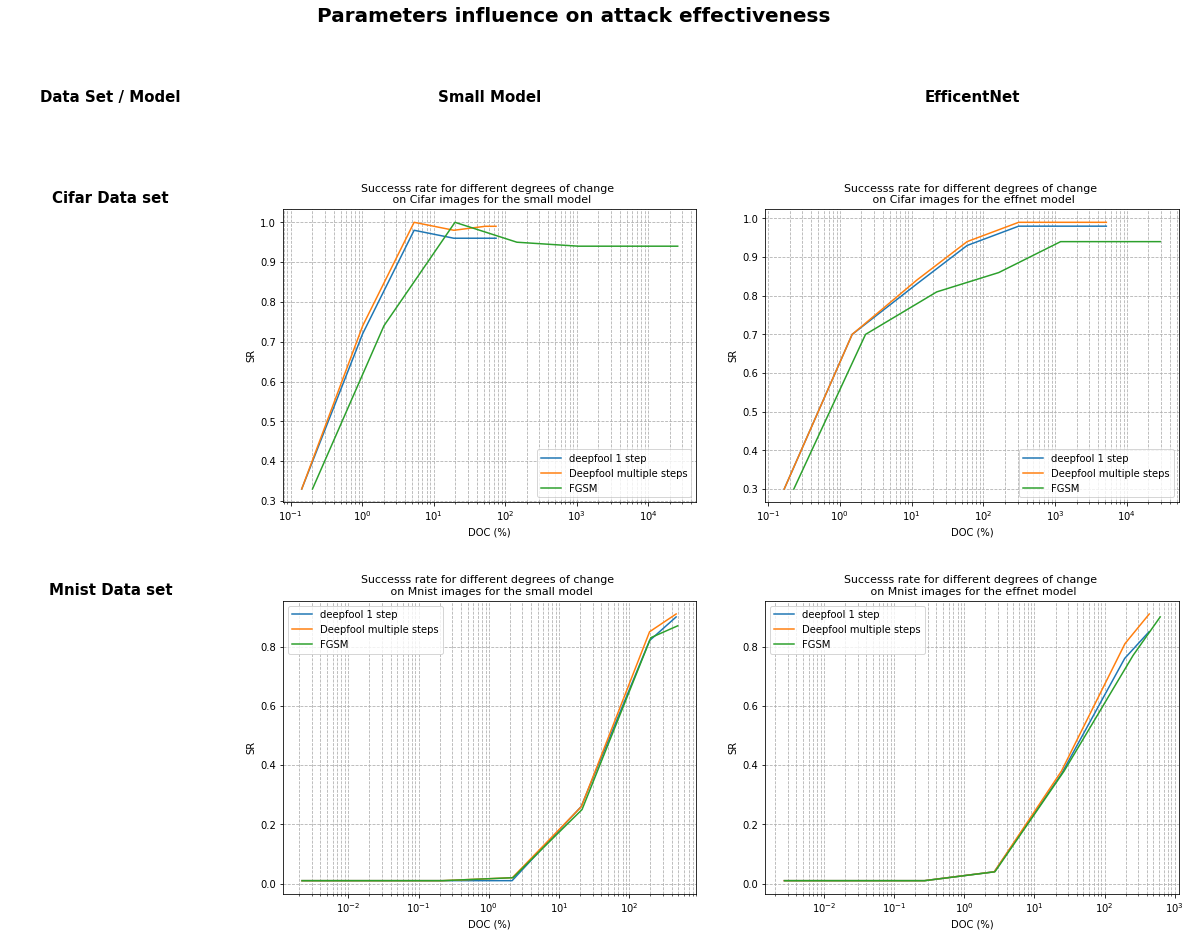

In [8]:
plt.rcParams["figure.figsize"] = 21,14
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, ax = plt.subplots(ncols=3, nrows=3, gridspec_kw={"height_ratios":[0.01,1,1],"width_ratios":[0.5,1,1]})
fig.suptitle('Parameters influence on attack effectiveness', 
             fontsize=20, fontweight='bold')


ax[0][0].axis("off")
ax[0][0].set_title("Data Set / Model", fontweight='bold',fontsize=15)


ax[0][1].axis("off")
ax[0][1].set_title("Small Model", fontweight='bold',fontsize=15)


ax[0][2].axis("off")
ax[0][2].set_title("EfficentNet", fontweight='bold',fontsize=15)


ax[1][0].axis("off")
ax[1][0].set_title("Cifar Data set", fontweight='bold',fontsize=15)



ax[2][0].axis("off")
ax[2][0].set_title("Mnist Data set", fontweight='bold',fontsize=15)


ax[1][1].plot(list(SR_deepfool_1step_dic_small_model_Cifar.keys()),list(SR_deepfool_1step_dic_small_model_Cifar.values()),label='deepfool 1 step')
ax[1][1].plot(list(SR_deepfool_mutliple_steps_dic_small_model_Cifar.keys()),list(SR_deepfool_mutliple_steps_dic_small_model_Cifar.values()),label='Deepfool multiple steps')
ax[1][1].plot(list(SR_FGSM_dic_small_model_Cifar.keys()),list(SR_FGSM_dic_small_model_Cifar.values()),label='FGSM')
ax[1][1].set_xscale('log')
ax[1][1].grid(True,which="both", linestyle='--')
ax[1][1].set_title('Successs rate for different degrees of change \n on Cifar images for the small model',fontsize=11)
ax[1][1].set_xlabel('DOC (%)')
ax[1][1].set_ylabel('SR')
ax[1][1].legend(loc='lower right')



ax[1][2].plot(list(SR_deepfool_1step_dic_model_effnet_Cifar.keys()),list(SR_deepfool_1step_dic_model_effnet_Cifar.values()),label='deepfool 1 step')
ax[1][2].plot(list(SR_deepfool_mutliple_steps_dic_model_effnet_Cifar.keys()),list(SR_deepfool_mutliple_steps_dic_model_effnet_Cifar.values()),label='Deepfool multiple steps')
ax[1][2].plot(list(SR_FGSM_dic_model_effnet_Cifar.keys()),list(SR_FGSM_dic_model_effnet_Cifar.values()),label='FGSM')
ax[1][2].set_xscale('log')
ax[1][2].grid(True,which="both", linestyle='--')
ax[1][2].set_title('Successs rate for different degrees of change \n on Cifar images for the effnet model',fontsize=11)
ax[1][2].set_xlabel('DOC (%)')
ax[1][2].set_ylabel('SR')
ax[1][2].legend(loc='lower right')






ax[2][1].plot(list(SR_deepfool_1step_dic_small_model_Mnist.keys()),list(SR_deepfool_1step_dic_small_model_Mnist.values()),label='deepfool 1 step')
ax[2][1].plot(list(SR_deepfool_mutliple_steps_dic_small_model_Mnist.keys()),list(SR_deepfool_mutliple_steps_dic_small_model_Mnist.values()),label='Deepfool multiple steps')
ax[2][1].plot(list(SR_FGSM_dic_small_model_Mnist.keys()),list(SR_FGSM_dic_small_model_Mnist.values()),label='FGSM')
ax[2][1].set_xscale('log')
ax[2][1].grid(True,which="both", linestyle='--')
ax[2][1].set_title('Successs rate for different degrees of change \n on Mnist images for the small model',fontsize=11)
ax[2][1].set_xlabel('DOC (%)')
ax[2][1].set_ylabel('SR')
ax[2][1].legend(loc='upper left')


ax[2][2].plot(list(SR_deepfool_1step_dic_model_effnet_Mnist.keys()),list(SR_deepfool_1step_dic_model_effnet_Mnist.values()),label='deepfool 1 step')
ax[2][2].plot(list(SR_deepfool_mutliple_steps_dic_model_effnet_Mnist.keys()),list(SR_deepfool_mutliple_steps_dic_model_effnet_Mnist.values()),label='Deepfool multiple steps')
ax[2][2].plot(list(SR_FGSM_dic_model_effnet_Mnist.keys()),list(SR_FGSM_dic_model_effnet_Mnist.values()),label='FGSM')
ax[2][2].set_xscale('log')
ax[2][2].grid(True,which="both", linestyle='--')
ax[2][2].set_title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
ax[2][2].set_xlabel('DOC (%)')
ax[2][2].set_ylabel('SR')
ax[2][2].legend(loc='upper left')





fig.subplots_adjust(hspace=0.5,bottom=0.1)
plt.show()